<a href="https://colab.research.google.com/github/RohanG610/Machine-Learning-with-Python/blob/main/SpeechEmotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
#importing the libraries
import pandas as pd
import numpy as np

import os
import sys

#for analyzing audio files and display it
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report #classification_report = us to make report on each classification showing precision,recall,f1-score,and support
from sklearn.model_selection import train_test_split

#to play the audio files
import IPython.display as ipd
from IPython.display import Audio

#To make model
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding #Ingeneral, embeddding means converting/mapping discrete values to continous vector
from keras.layers import LSTM, BatchNormalization, GRU
# from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Input,Flatten,Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)
import tensorflow as tf

#Import Libraries
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03
= audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [35]:
#preparing dataset

ravdess = "/content/drive/MyDrive/dataset/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_23', 'Actor_22', 'Actor_24', 'Actor_21', 'Actor_18', 'Actor_20', 'Actor_15', 'Actor_19', 'Actor_16', 'Actor_17', 'Actor_09', 'Actor_13', 'Actor_11', 'Actor_14', 'Actor_07', 'Actor_12', 'Actor_08', 'Actor_10', 'Actor_05', 'Actor_06', 'Actor_02', 'Actor_03', 'Actor_01', 'Actor_04']


##Data Preprocessing

In [36]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
  actor = os.listdir(ravdess+i)
  for f in actor:
    part = f.split(".")[0].split('-')
    file_emotion.append(int(part[2]))
    file_path.append(ravdess+i+'/'+f)


In [37]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-01-01-02-02-04.wav
03
/content/drive/MyDrive/dataset/audio_speech_actors_01-24/Actor_23/03-01-03-01-01-02-23.wav
6
03-01-06-02-01-01-04.wav


In [38]:
#Converting it into a dataframe

#dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion,columns=['Emotions'])
#datafreame for path of files
path_df = pd.DataFrame(file_path,columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
#chaning integers to actual emoitions
ravdess_df.Emotions.replace({1:'Neutral', 2:"Clam", 3:"Happy", 4:"Sad",5:"Angry", 6:"Fear",
                             7:'Disgust',8:"Suprise"},inplace=True)

In [39]:
#displaying new dataframe
print(ravdess_df.head())
#value counts
print(ravdess_df.Emotions.value_counts())

  Emotions                                               Path
0    Happy  /content/drive/MyDrive/dataset/audio_speech_ac...
1  Neutral  /content/drive/MyDrive/dataset/audio_speech_ac...
2    Happy  /content/drive/MyDrive/dataset/audio_speech_ac...
3     Clam  /content/drive/MyDrive/dataset/audio_speech_ac...
4     Clam  /content/drive/MyDrive/dataset/audio_speech_ac...
Happy      192
Clam       192
Angry      192
Fear       192
Disgust    192
Sad        192
Suprise    192
Neutral     96
Name: Emotions, dtype: int64


##Data Visualization

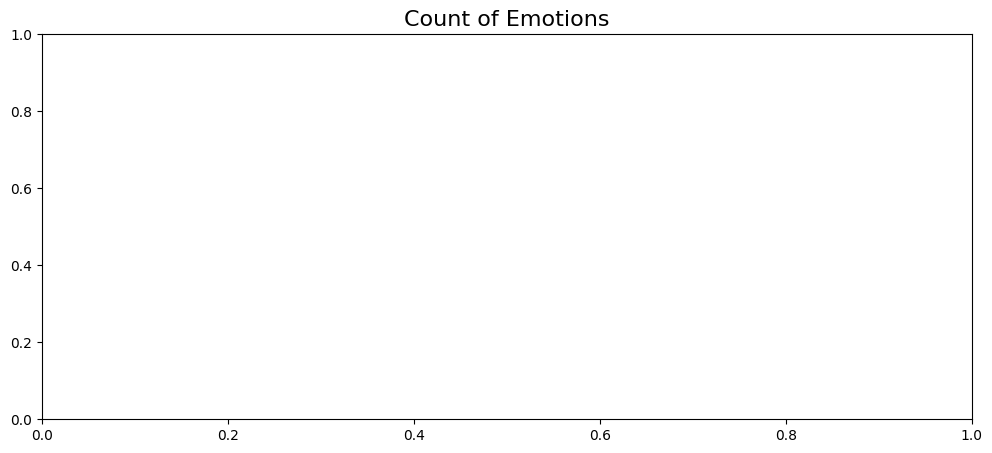

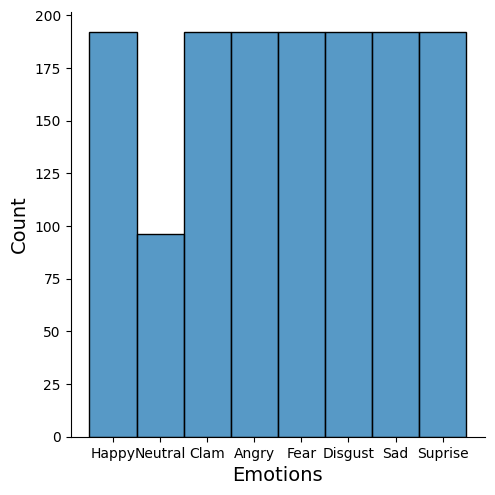

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,5))
plt.title('Count of Emotions', size=16)
sns.displot(ravdess_df['Emotions'])
plt.xlabel('Emotions',size=14)
plt.ylabel('Count',size=14)
plt.show()

In [41]:
data, sr = librosa.load(file_path[0])
sr

22050

In [42]:
ipd.Audio(data,rate = sr)

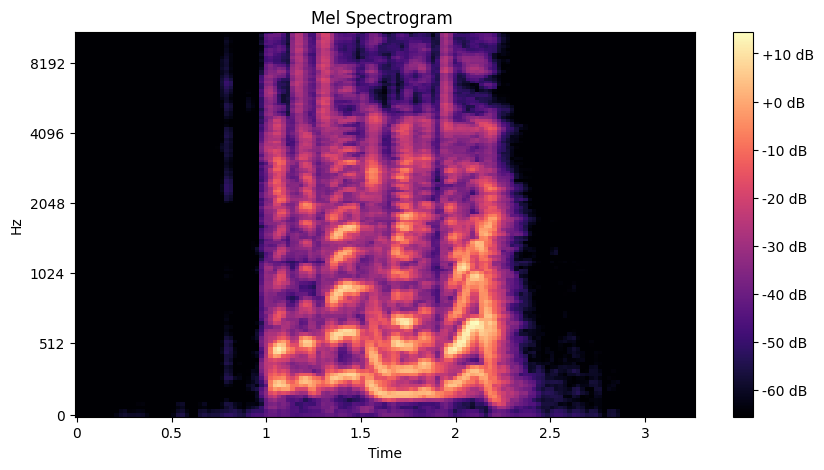

In [43]:
#Create log mel spectrogram
plt.figure(figsize=(10,5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time')
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

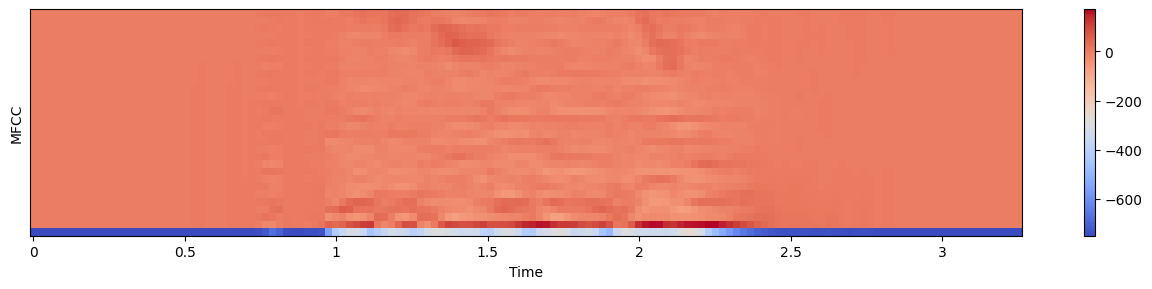

In [44]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)

#mfcc
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data, rate=sr)

## Data Augmentation

In [45]:
#NOISE
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

#STRETCH
def stretch_audio(data, rate=0.8):
  return librosa.effects.time_stretch(y = data,rate = rate)

#SHIFT
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high=5)*1000)
  return np.roll(data, shift_range)

#PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(y = data,sr = sampling_rate,n_steps = pitch_factor)

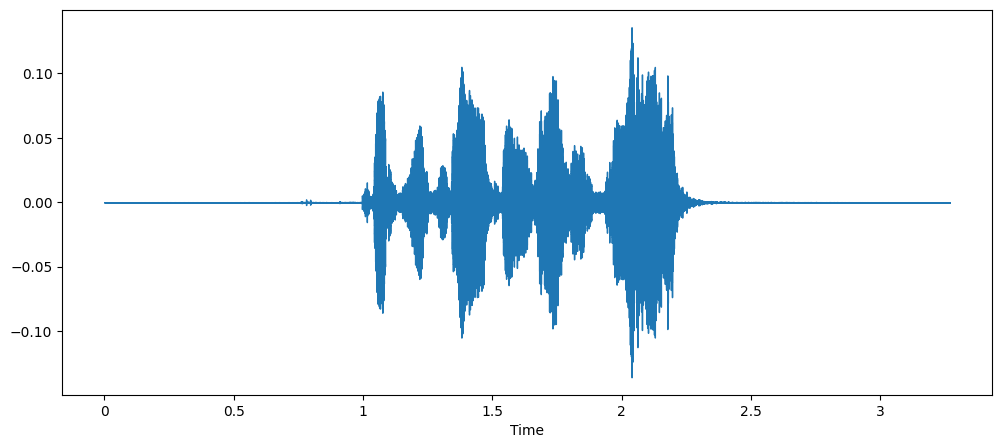

In [46]:
# Normal Audio

plt.figure(figsize=(12,5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data, rate=sr)

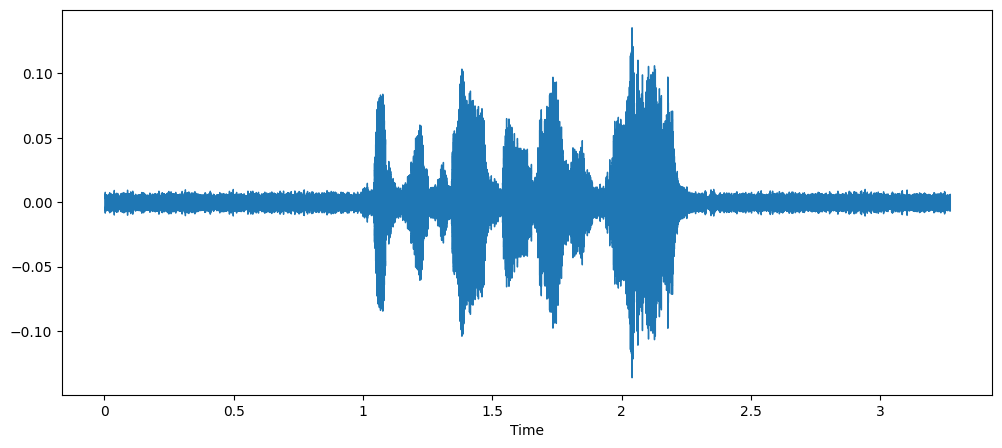

In [47]:
#Audio with Noise
x = noise(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

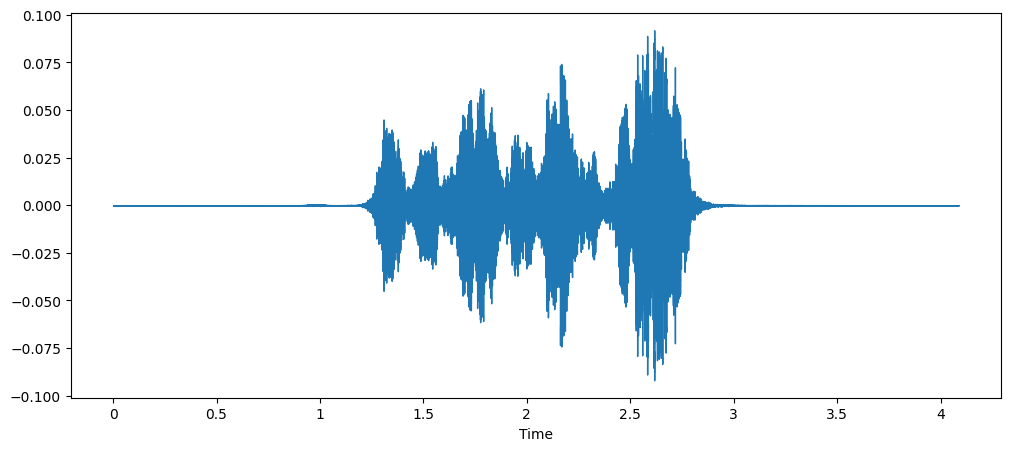

In [48]:
#Stretched Audio
x = stretch_audio(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

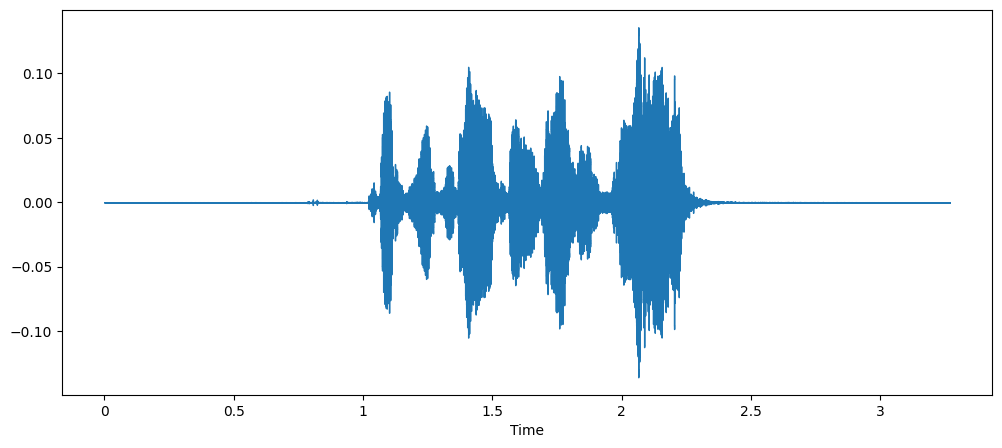

In [49]:
#Shifted Audio
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

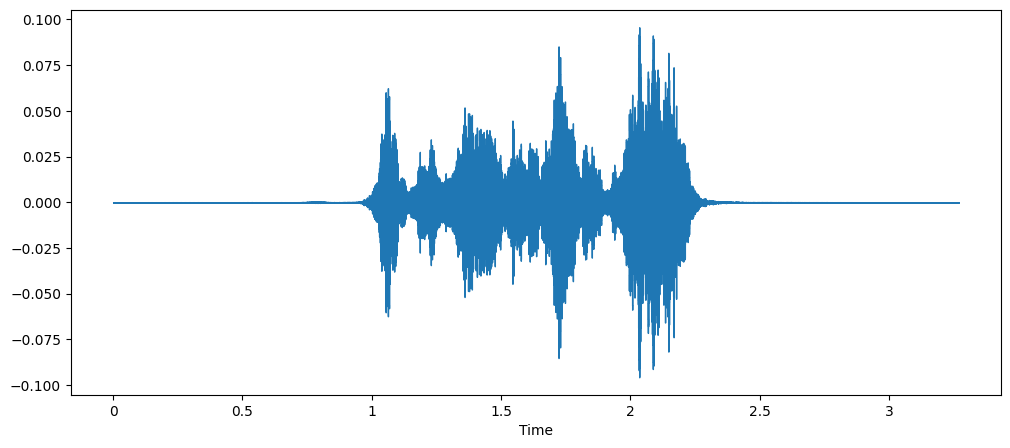

In [50]:
#Audio with Pitch
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

##Feature Extraction

In [51]:
def feat_ext(data):
    #Time_domain_features
    # ZCR Persody features or Low level ascoustic features
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
    #Frequency_domain_features
    #Spectral and wavelet Features
    #MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr,n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    return result

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch_audio(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [52]:
import multiprocessing as mp
print("Number of processors: ",mp.cpu_count())

Number of processors:  2


##Normal way to get features

In [53]:
ravdess_df

,Emotions,Path
0,Happy,/content/drive/MyDrive/dataset/audio_speech_ac...
1,Neutral,/content/drive/MyDrive/dataset/audio_speech_ac...
2,Happy,/content/drive/MyDrive/dataset/audio_speech_ac...
3,Clam,/content/drive/MyDrive/dataset/audio_speech_ac...
4,Clam,/content/drive/MyDrive/dataset/audio_speech_ac...
...,...,...
1435,Angry,/content/drive/MyDrive/dataset/audio_speech_ac...
1436,Suprise,/content/drive/MyDrive/dataset/audio_speech_ac...
1437,Disgust,/content/drive/MyDrive/dataset/audio_speech_ac...
1438,Fear,/content/drive/MyDrive/dataset/audio_speech_ac...


In [21]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
X , Y = [], []
for path, emotion in zip(ravdess_df['Path'] , ravdess_df['Emotions']):
  feature = get_feat(path)
  for ele in feature:
    X.append(ele)
    Y.append(emotion)
stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  655.864041857


##Faster way to get features

In [22]:
# from joblib import Parallel, delayed
# import timeit
# start = timeit.default_timer()
# # Define a function to get features for a single audio file
# def get_features(path, emotion):
#   feature = get_feat(path)
#   X, Y = [], []
#   for ele in feature:
#     X.append(ele)
#     Y.append(emotion)
#   return X,Y

# #Call the get_features function in paralled for all audio files
# X, Y = [], []
# for path, emotion in zip(ravdess_df['Path'], ravdess_df['Emotions']):
#   results = Parallel(n_jobs=-1)(delayed(get_features)(path, emotion))
# for result in results:
#   X.extend(result[0])
#   Y.extend(result[1])
# stop = timeit.default_timer()
# print('Time:', stop - start)

In [23]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Emotions
0,0.302079,-533.581787,56.394810,-9.432840,2.665695,5.560278,-7.058790,-6.993605,-8.550489,-13.477795,...,2.800840,0.719491,-0.406532,-0.825472,0.358698,0.378936,0.985918,-1.569112,1.099683,Happy
1,0.330471,-306.958738,21.584767,1.305253,0.145987,-0.167907,-3.635308,-5.133524,-6.424127,-7.840462,...,1.998945,0.439789,-0.933729,-1.050533,-0.503301,-0.142933,-0.998237,-1.308163,0.135524,Happy
2,0.172352,-584.653748,53.963440,-12.059545,2.528184,3.711617,-8.839359,-8.330457,-10.805763,-13.489388,...,2.095854,-1.296361,1.358551,0.660017,1.830770,0.066656,-0.148516,-0.233925,3.237530,Happy
3,0.208989,-550.074524,90.382851,-9.742638,10.783862,16.361797,-11.176653,-7.445179,-8.094001,-15.270140,...,-2.058327,-5.542691,-1.864955,-5.265106,0.784993,-1.734253,0.639966,-1.767727,1.156348,Neutral
4,0.199223,-507.608681,72.593179,-8.375672,10.362574,14.109679,-10.596389,-7.715555,-7.588503,-14.163802,...,-3.123521,-5.022188,-2.253429,-4.319944,-0.125249,-1.577308,-0.094147,-1.323920,0.846373,Neutral


In [24]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Emotions
0,0.302079,-533.581787,56.394810,-9.432840,2.665695,5.560278,-7.058790,-6.993605,-8.550489,-13.477795,...,2.800840,0.719491,-0.406532,-0.825472,0.358698,0.378936,0.985918,-1.569112,1.099683,Happy
1,0.330471,-306.958738,21.584767,1.305253,0.145987,-0.167907,-3.635308,-5.133524,-6.424127,-7.840462,...,1.998945,0.439789,-0.933729,-1.050533,-0.503301,-0.142933,-0.998237,-1.308163,0.135524,Happy
2,0.172352,-584.653748,53.963440,-12.059545,2.528184,3.711617,-8.839359,-8.330457,-10.805763,-13.489388,...,2.095854,-1.296361,1.358551,0.660017,1.830770,0.066656,-0.148516,-0.233925,3.237530,Happy
3,0.208989,-550.074524,90.382851,-9.742638,10.783862,16.361797,-11.176653,-7.445179,-8.094001,-15.270140,...,-2.058327,-5.542691,-1.864955,-5.265106,0.784993,-1.734253,0.639966,-1.767727,1.156348,Neutral
4,0.199223,-507.608681,72.593179,-8.375672,10.362574,14.109679,-10.596389,-7.715555,-7.588503,-14.163802,...,-3.123521,-5.022188,-2.253429,-4.319944,-0.125249,-1.577308,-0.094147,-1.323920,0.846373,Neutral


## Data Preparation

In [25]:
X = Emotions.iloc[:, :-1].values
Y = Emotions['Emotions'].values

In [26]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 41), (3240, 8), (1080, 41), (1080, 8))

In [28]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [29]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 41), (3240, 8), (1080, 41), (1080, 8))

In [54]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [55]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,mode='auto')
es=EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

##LSTM

In [56]:
model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
# model01.add(Dropout(0.2))
# model01.add(LSTM(128,return_sequences=True))
# model01.add(Dropout(0.2))
# model01.add(LSTM(128,return_sequences=True))
# model01.add(Dropout(0.2))
# model01.add(LSTM(128,return_sequences=True))
# model01.add(Dropout(0.2))
# model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(LSTM(128))
model01.add(Dropout(0.2))
model01.add(Dense(8,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 41, 128)           66560     
                                                                 
 dropout_7 (Dropout)         (None, 41, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 41, 128)           131584    
                                                                 
 dropout_8 (Dropout)         (None, 41, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                

In [57]:
hist=model01.fit(X_train, y_train,
            epochs=100,
            validation_data=(X_test, y_test),batch_size=65,
            verbose=1)

Epoch 1/100
50/50 [==============================] - 43s 716ms/step - loss: 1.9447 - accuracy: 0.2423 - val_loss: 1.8075 - val_accuracy: 0.2944
Epoch 2/100
50/50 [==============================] - 27s 533ms/step - loss: 1.8148 - accuracy: 0.3037 - val_loss: 1.7677 - val_accuracy: 0.3287
Epoch 3/100
50/50 [==============================] - 18s 368ms/step - loss: 1.7622 - accuracy: 0.3145 - val_loss: 1.7244 - val_accuracy: 0.3444
Epoch 4/100
50/50 [==============================] - 18s 369ms/step - loss: 1.6962 - accuracy: 0.3559 - val_loss: 1.6827 - val_accuracy: 0.3426
Epoch 5/100
50/50 [==============================] - 19s 370ms/step - loss: 1.6597 - accuracy: 0.3698 - val_loss: 1.6396 - val_accuracy: 0.3778
Epoch 6/100
50/50 [==============================] - 19s 384ms/step - loss: 1.6578 - accuracy: 0.3627 - val_loss: 1.6642 - val_accuracy: 0.3731
Epoch 7/100
50/50 [==============================] - 19s 379ms/step - loss: 1.6209 - accuracy: 0.3790 - val_loss: 1.6206 - val_accuracy:

34/34 [==============================] - 2s 71ms/step - loss: 1.5224 - accuracy: 0.6648
Accuracy of our model on test data :  66.4814829826355 %


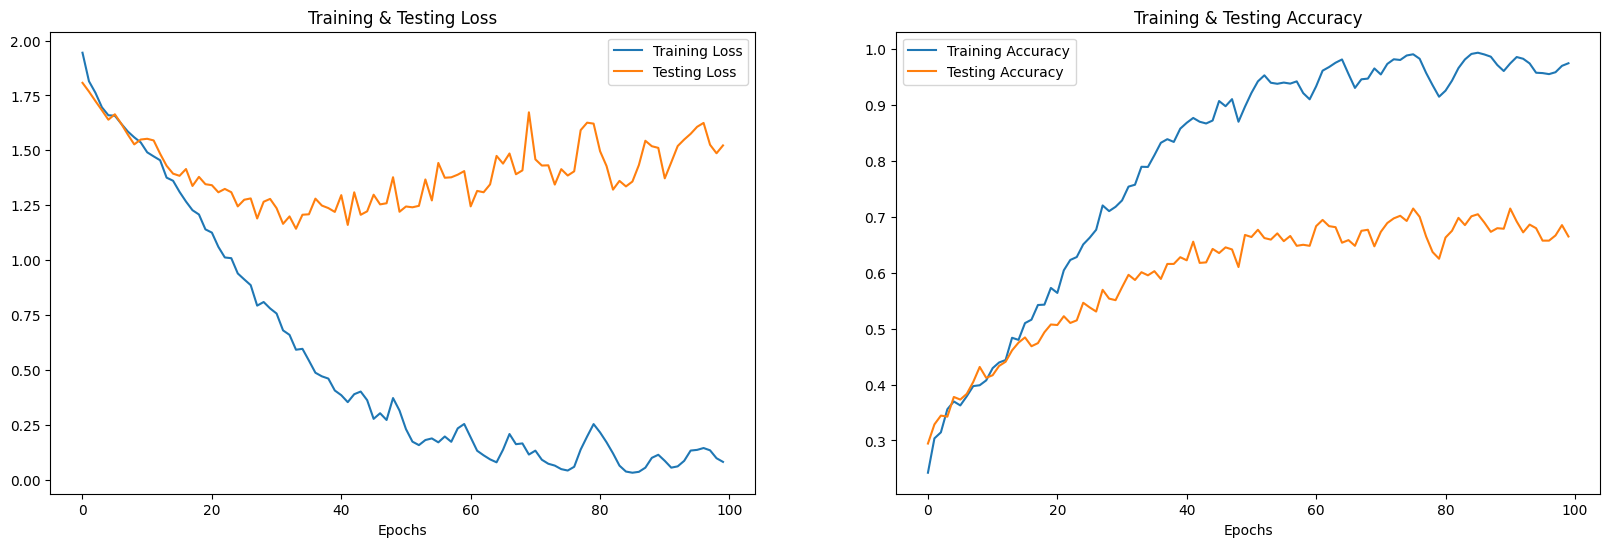

In [58]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [59]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((3240, 41, 1), (3240, 8), (1080, 41, 1), (1080, 8))

In [60]:
#Build the model

# define model
model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))


model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True))
model000.add(LSTM(128, return_sequences=True))
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(8, activation='softmax'))



model000.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 41, 1024)          6144      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 21, 1024)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 21, 1024)         4096      
 ormalization)                                                   
                                                                 
 dropout_10 (Dropout)        (None, 21, 1024)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 512)           2621952   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 512)         

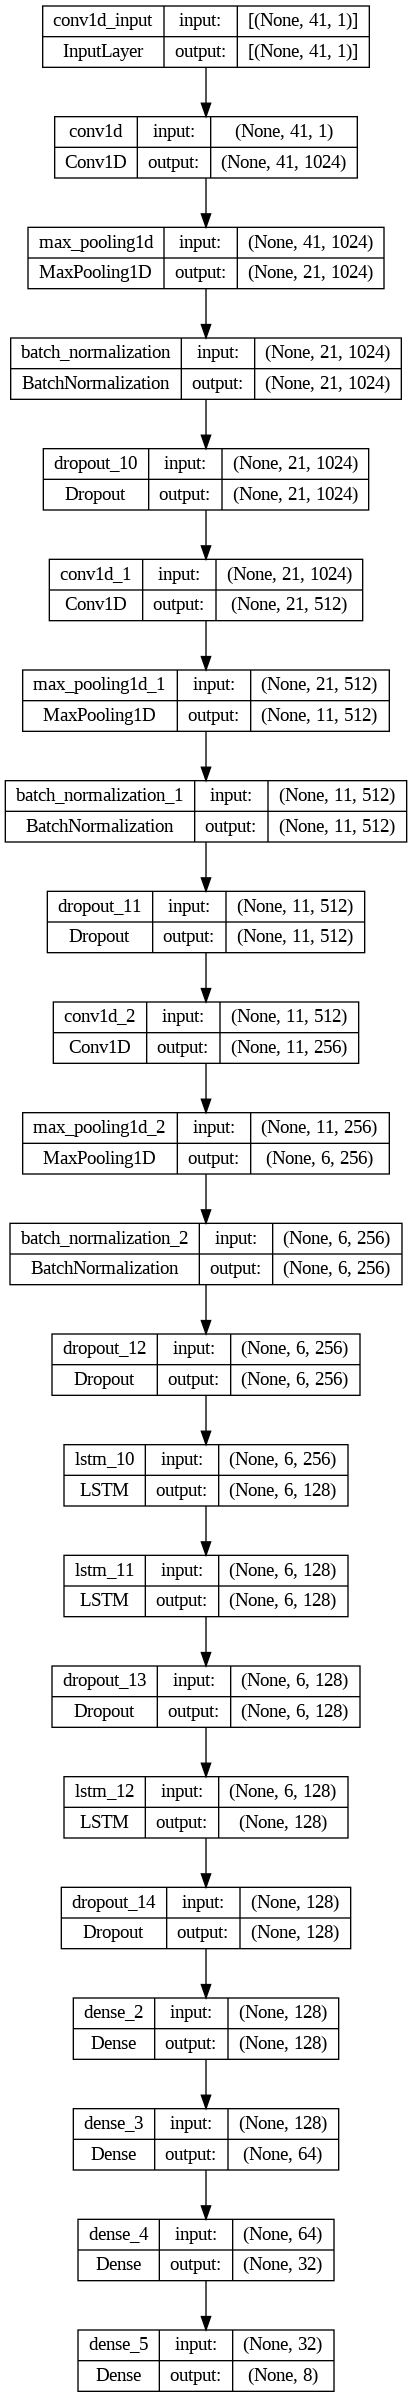

In [61]:
from keras.utils.vis_utils import plot_model
plot_model( model000, show_shapes=True, show_layer_names=True, to_file='model000.png')

In [62]:
model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
hist1=model000.fit(x_traincnn, y_train, batch_size=64, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
51/51 [==============================] - 81s 1s/step - loss: 2.0127 - accuracy: 0.2191 - val_loss: 2.1397 - val_accuracy: 0.1343
Epoch 2/100
51/51 [==============================] - 66s 1s/step - loss: 1.7833 - accuracy: 0.3136 - val_loss: 2.7873 - val_accuracy: 0.1343
Epoch 3/100
51/51 [==============================] - 65s 1s/step - loss: 1.6335 - accuracy: 0.3830 - val_loss: 2.3080 - val_accuracy: 0.1481
Epoch 4/100
51/51 [==============================] - 66s 1s/step - loss: 1.4871 - accuracy: 0.4410 - val_loss: 2.5378 - val_accuracy: 0.1343
Epoch 5/100
51/51 [==============================] - 65s 1s/step - loss: 1.3554 - accuracy: 0.5031 - val_loss: 2.2403 - val_accuracy: 0.2241
Epoch 6/100
51/51 [==============================] - 65s 1s/step - loss: 1.2202 - accuracy: 0.5457 - val_loss: 1.9590 - val_accuracy: 0.2991
Epoch 7/100
51/51 [==============================] - 65s 1s/step - loss: 1.0938 - accuracy: 0.6000 - val_loss: 1.8562 - val_accuracy: 0.2861
Epoch 8/100
5

34/34 [==============================] - 8s 225ms/step - loss: 0.8157 - accuracy: 0.8250
Accuracy of our model on test data :  82.4999988079071 %


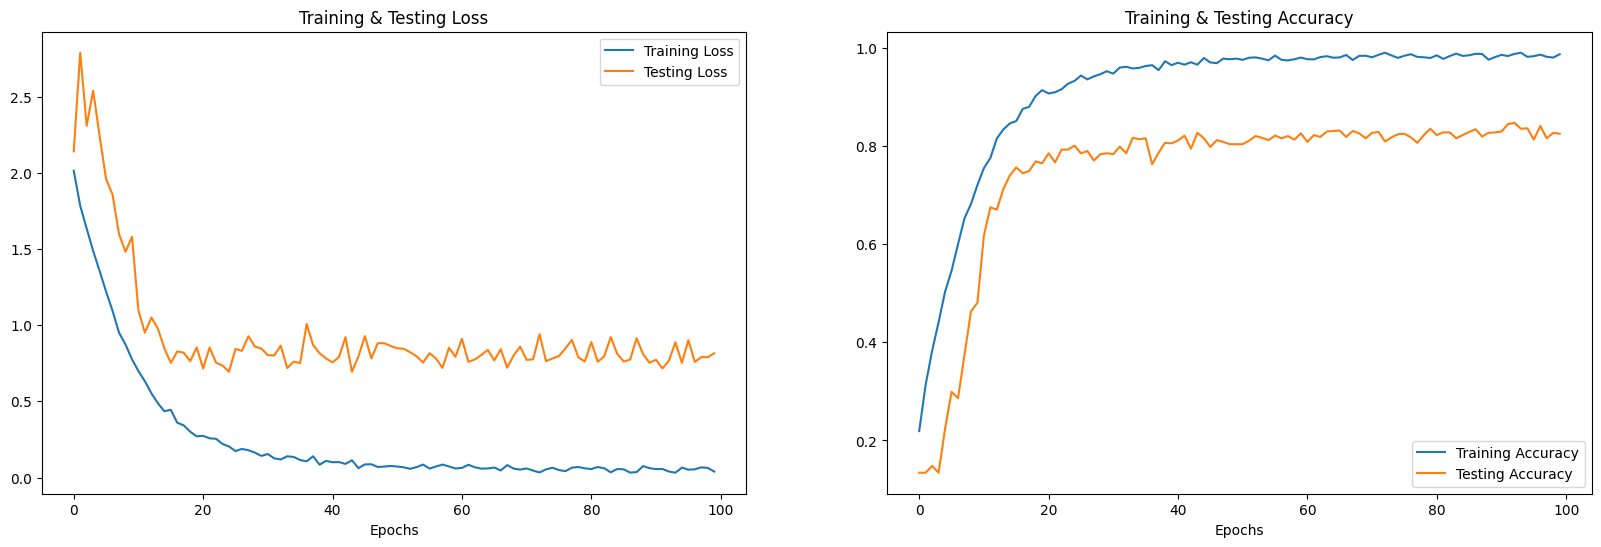

In [64]:
print("Accuracy of our model on test data : " , model000.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [69]:
# predicting on test data.
pred_test00 = model000.predict(x_testcnn)
y_pred00 = encoder.inverse_transform(pred_test00)
y_test00 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred00.flatten()
df0['Actual Labels'] = y_test00.flatten()

df0.head(10)

34/34 [==============================] - 6s 177ms/step


,Predicted Labels,Actual Labels
0,Sad,Sad
1,Happy,Disgust
2,Angry,Disgust
3,Clam,Clam
4,Sad,Sad
5,Suprise,Suprise
6,Disgust,Disgust
7,Happy,Happy
8,Fear,Fear
9,Angry,Angry


In [66]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test00, y_pred00)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test00, y_pred00))

NameError: ignored

In [68]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model000.to_json()
with open("cnnlstmmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model000.save_weights("cnnlstmmodel000.h5")
print("Saved model to disk")

Saved model to disk
